# Simulation using Concord

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import Concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [17]:
proj_name = "simulation_tree_singlebatch"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
# device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

'Feb04-1304'

In [18]:
group_key = 'depth'
batch_key = 'batch'
state_key = 'branch'
leiden_key = 'leiden_no_noise'
time_key = 'time'
state_type = 'tree'
batch_type = 'batch_specific_features'
distribution = 'normal'

In [19]:
from Concord.utils.simulation import Simulation

sim = Simulation(n_cells=5000, n_genes=3000, n_batches=1, n_states=3, 
                 state_type=state_type, 
                 state_distribution = distribution, 
                 state_level=10, 
                 state_min_level=1,
                 state_dispersion=5.0, 
                 program_structure='linear_increasing',
                 program_on_time_fraction=0.2,
                 trajectory_program_num=4,
                 trajectory_loop_to=1,
                 tree_branching_factor=[3,5,8],
                 tree_depth=3,
                 tree_program_decay=0.4,
                 tree_cellcount_decay=0.5,
                 batch_distribution=distribution,
                 batch_type=batch_type, 
                 batch_level=[10,10], 
                 batch_dispersion=[5.0, 5.0], 
                 non_neg=True, to_int=True,
                 seed=42)

# Generate the simulated data
adata, adata_state = sim.simulate_data()


Concord.utils.simulation - WARNING - Total number of genes will not be equal to n_genes due to program_decay < 1.
Concord.utils.simulation - WARNING - Total number of cells will not be equal to n_cells due to cellcount_decay < 1.


In [20]:
# check if nan exists in adata.X
if np.isnan(adata.X).sum() > 0:
    print(f"nan exists in adata.X")

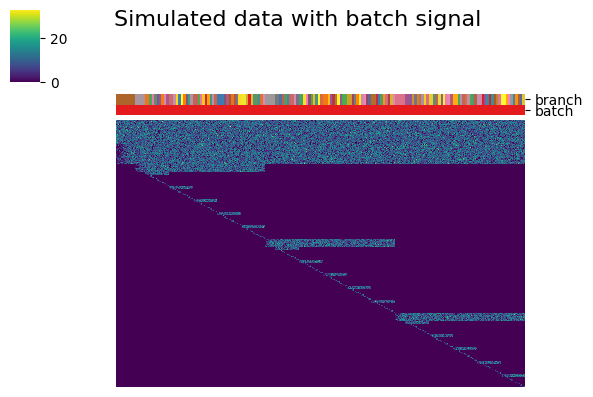

In [21]:
#ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)
#ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)

In [22]:
concord_args_base = {
    'input_feature': None,
    'latent_dim': 100,
    'encoder_dims':[300],
    'decoder_dims':[300],
    'batch_size':16,
    'n_epochs': 10,
    'p_intra_knn': 0.0,
    'lr': 1e-2,
    'schedule_ratio': 0.97,
    'augmentation_mask_prob': 0.3,
    'clr_temperature':0.2,
    'sampler_knn':300,
    'dist_metric':'euclidean',
    'domain_key': batch_key,
    'seed': seed,
    'device': device,
    'save_dir': save_dir
}

file_suffix = f"{time.strftime('%b%d-%H%M')}_batchsize{concord_args_base['batch_size']}_latentdim{concord_args_base['latent_dim']}"
file_suffix

'Feb04-1304_batchsize16_latentdim100'

In [23]:
import copy
param_variations = {
    'p_intra_knn': [0.0, 0.3, 0.5, 0.7, 0.9],  # Example: vary p_intra_knn
    #'batch_size': [16, 32, 64, 128, 256, 512],  # Example: vary batch_size
    #'sampler_knn': [5, 10, 20, 30, 40, 50, 100]  # Example: vary sampler_knn
}
param_keys = []

# -------------------------------------
# 3. Loop over each parameter to vary
# -------------------------------------
for param_name, values in param_variations.items():
    print(f"\n[INFO] Varying '{param_name}' with possible values: {values}\n")
    
    for value in values:
        # 3a. Copy the base arguments
        concord_args = copy.deepcopy(concord_args_base)
        
        # 3b. Update the specific parameter we want to vary
        concord_args[param_name] = value
        
        # 3c. Indicate which param is varied and to which value
        output_key = f"Concord_{param_name}_{value}"
        # Append output_key to param_keys
        param_keys.append(output_key)
        umap_key   = output_key + '_UMAP'

        print(f"[INFO] Running Concord with {param_name} = {value}")
        
        # -------------------------------------
        # 4. Run Concord
        # -------------------------------------
        cur_ccd = ccd.Concord(adata, **concord_args)

        # Encode data, saving the latent embedding in adata.obsm[output_key]
        cur_ccd.encode_adata(
            input_layer_key='X',
            output_key=output_key,
            preprocess=False
        )
        
        # -------------------------------------
        # 5. (Optional) run UMAP on the new embedding
        # -------------------------------------
        ccd.ul.run_umap(
            adata,
            source_key=output_key,
            result_key=umap_key,
            n_components=2,
            n_neighbors=30,
            min_dist=0.5,
            metric='cosine',
            random_state=seed
        )
        

print("[DONE] Finished varying each parameter individually.")



[INFO] Varying 'p_intra_knn' with possible values: [0.0, 0.3, 0.5, 0.7, 0.9]

[INFO] Running Concord with p_intra_knn = 0.0
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.0


Epoch 0 Training: 244it [00:03, 80.57it/s, loss=7.97]
Epoch 9 Training: 100%|██████████| 244/244 [00:03<00:00, 78.07it/s, loss=7.51]


[INFO] Running Concord with p_intra_knn = 0.3
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.3


Epoch 0 Training: 244it [00:03, 72.81it/s, loss=8.17]
Epoch 9 Training: 100%|██████████| 244/244 [00:03<00:00, 78.39it/s, loss=7.16]


[INFO] Running Concord with p_intra_knn = 0.5
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.5


Epoch 0 Training: 244it [00:03, 81.00it/s, loss=8.57]
Epoch 9 Training: 100%|██████████| 244/244 [00:03<00:00, 76.77it/s, loss=7.31]


[INFO] Running Concord with p_intra_knn = 0.7
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.7


Epoch 0 Training: 244it [00:02, 82.94it/s, loss=9.92]
Epoch 9 Training: 100%|██████████| 244/244 [00:03<00:00, 79.93it/s, loss=7.64]


[INFO] Running Concord with p_intra_knn = 0.9
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.9


Epoch 0 Training: 244it [00:03, 80.81it/s, loss=10.3]
Epoch 9 Training: 100%|██████████| 244/244 [00:03<00:00, 79.31it/s, loss=8.12]


[DONE] Finished varying each parameter individually.


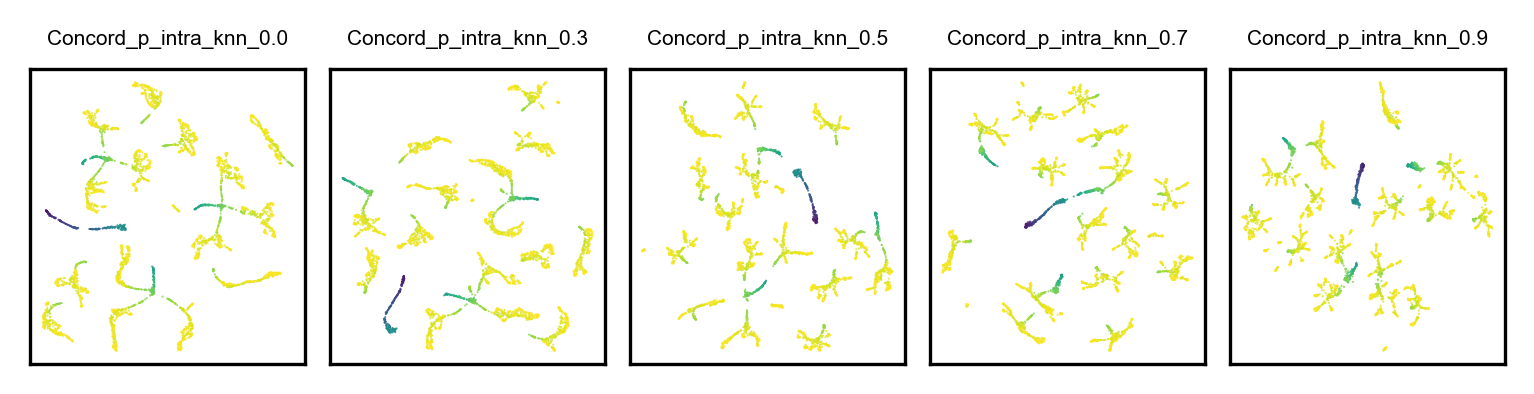

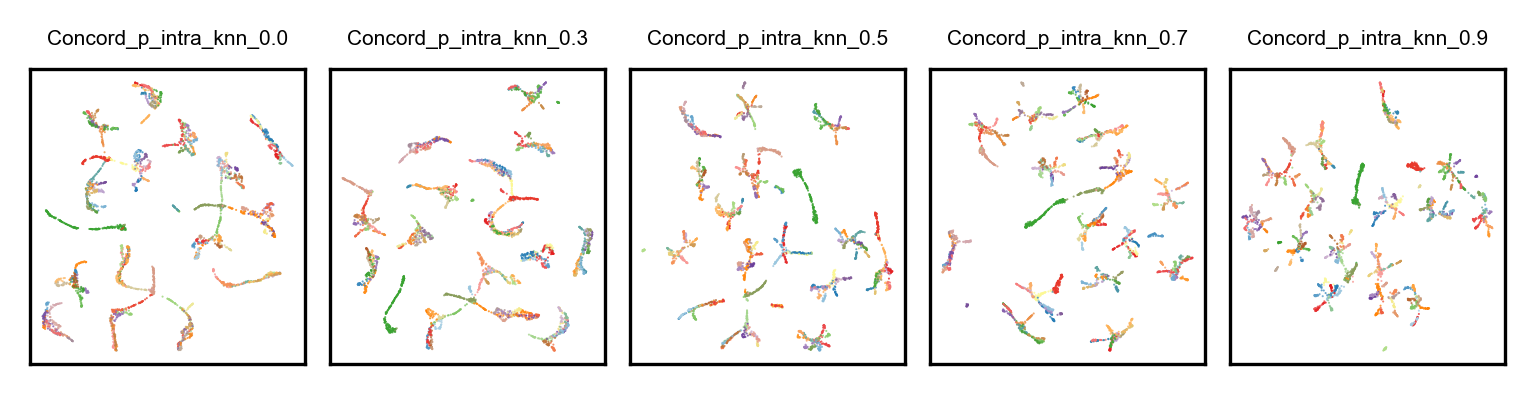

In [24]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rcParams

file_suffix = f"{time.strftime('%b%d-%H%M')}"
# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

color_bys = ['time', state_key]
#basis_types = ['', 'PAGA', 'KNN', 'PCA', 'UMAP']
#basis_types = ['KNN', 'UMAP']
basis_types = ['UMAP']
font_size=5
point_size=1
alpha=0.8
figsize=(6,1.2)
ncols = 6
nrows = int(np.ceil(len(param_keys) / ncols))
pal = {'time':'viridis', state_key:'Paired', batch_key:'Set1'}
k=15
edges_color='grey'
edges_width=0.05
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        param_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=1,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix,
        save_format='pdf'
    )


In [149]:
# Run UMAP on sub branches
adata_sub = adata[adata.obs['depth'] == 0].copy()
for output_key in param_keys:
    ccd.ul.run_umap(
        adata_sub,
        source_key=output_key,
        result_key=output_key+'_UMAP_sub',
        n_components=2,
        n_neighbors=30,
        min_dist=0.5,
        metric='cosine',
        random_state=seed
    )

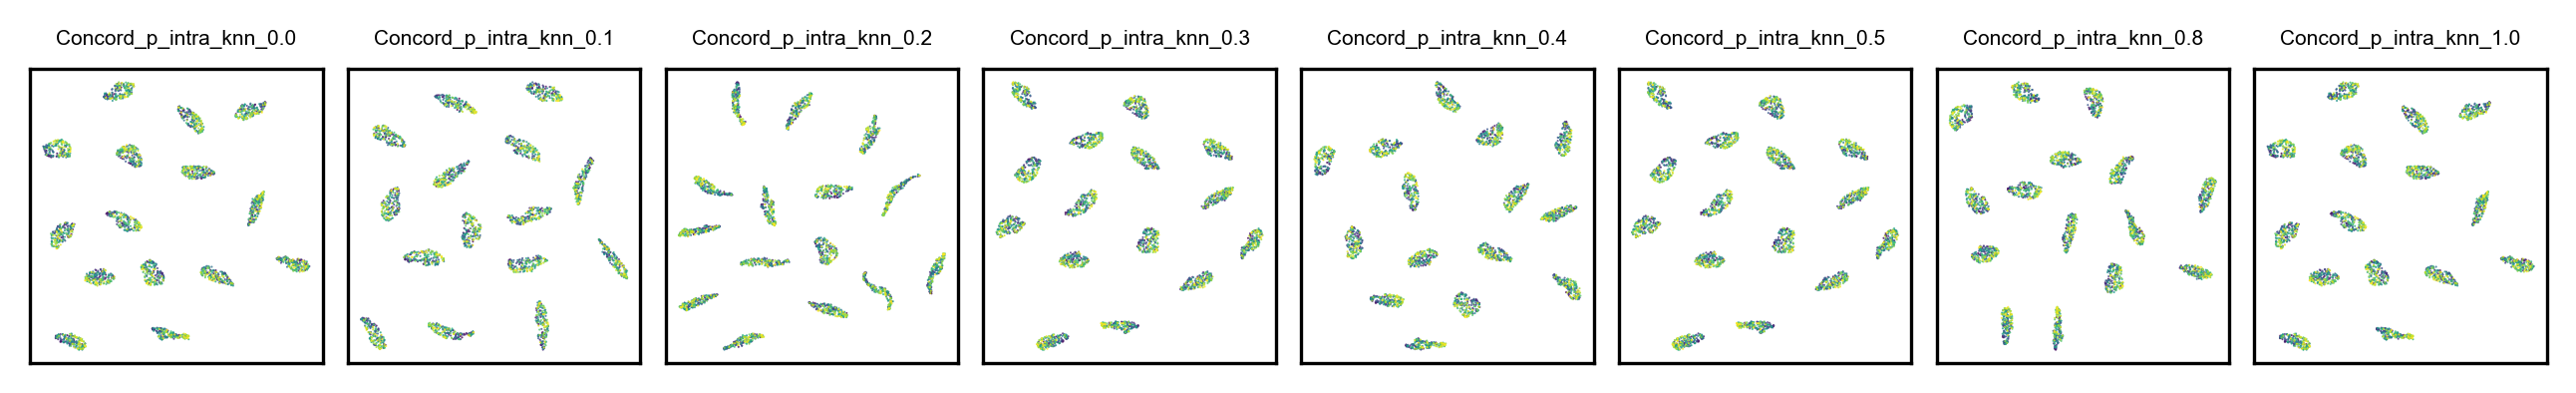

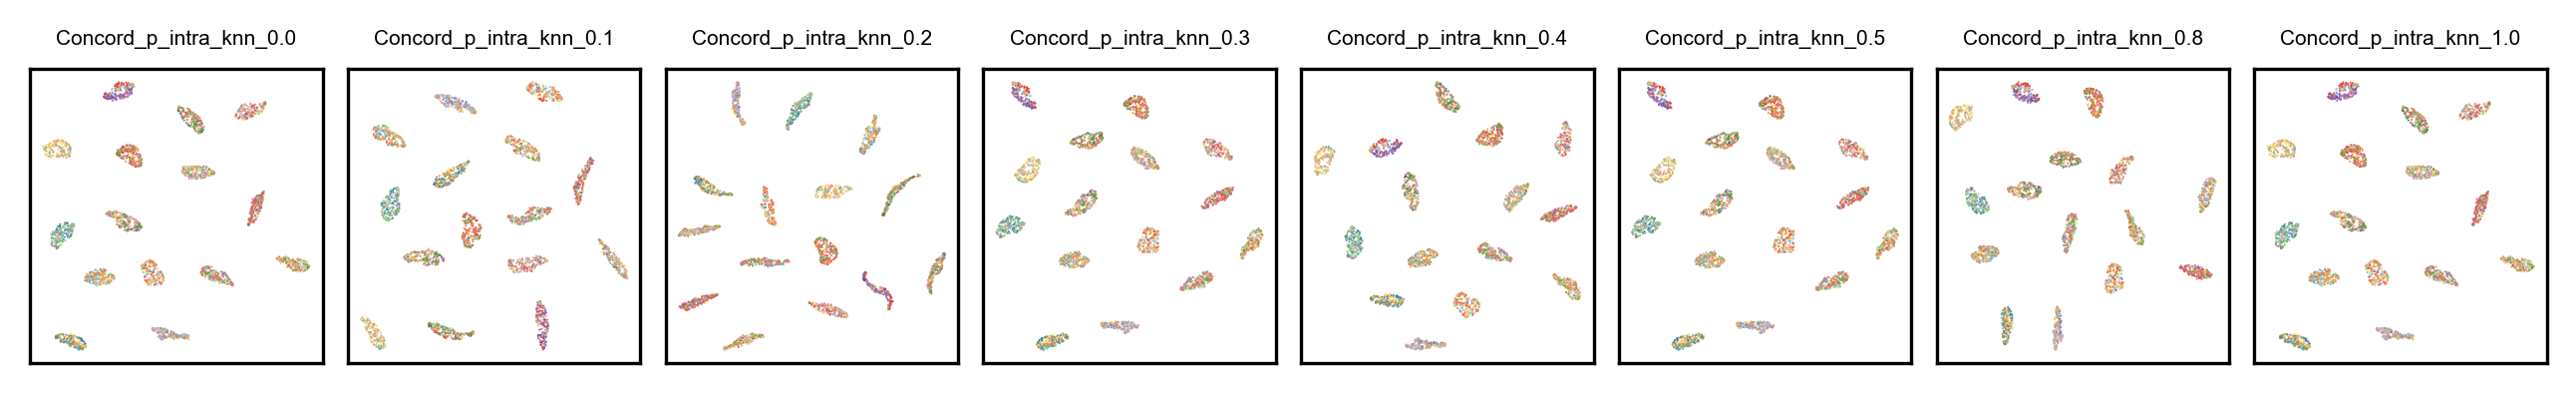

In [ ]:
basis_types = ['UMAP_sub']
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata_sub,
        param_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=1,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix,
        save_format='pdf'
    )


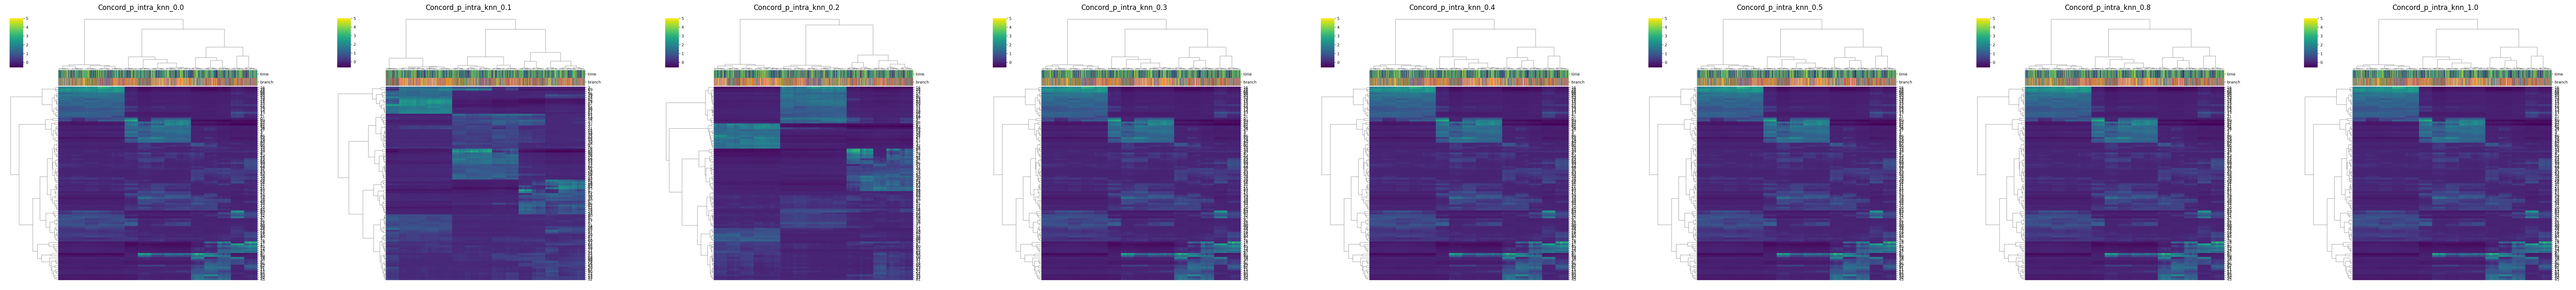

In [152]:
ncols = len(param_keys)
    
# Create a figure with subplots
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]))
figsize=(10,10)
# Plot heatmaps for each layer
glist = []
for i, key in enumerate(param_keys):

    g = ccd.pl.heatmap_with_annotations(
        adata_sub, 
        key, 
        obs_keys=color_bys, 
        cmap='viridis', 
        cluster_rows=True, 
        cluster_cols=True, 
        value_annot=False, 
        vmax = 5,
        figsize=figsize,
        show=False
    )
        
    # Save the clustermap figure to a buffer
    from io import BytesIO
    buf = BytesIO()
    g.figure.savefig(buf, format='png', dpi=300)
    buf.seek(0)

    # Load the image from the buffer and display it in the subplot
    import matplotlib.image as mpimg
    img = mpimg.imread(buf)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'{key}')

    # Close the clustermap figure to free memory
    plt.close(g.figure)
    buf.close()



plt.savefig(save_dir/f'heatmap_all_{file_suffix}_subset.png', dpi=300, bbox_inches='tight')


In [136]:
cur_ccd.init_dataloader(input_layer_key="X_log1p", use_sampler=True)

Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 1.0


In [153]:
import numpy as np
dataloader = cur_ccd.loader[0][0]
# from 0 to 100
batch_indices = np.arange(10)
data_structure = cur_ccd.data_structure
attribute = 'idx'
hl_indices = []
found_indices = set()

for batch_idx, batch in enumerate(dataloader):
    if batch_idx in batch_indices:
        attr_data = batch[data_structure.index(attribute)].cpu()
        hl_indices.append(attr_data)
        found_indices.add(batch_idx)
        if len(found_indices) == len(batch_indices):
            break

hl_indices

[tensor([   0,    1,    2,  ..., 1021, 1022, 1023]),
 tensor([1024, 1025, 1026,  ..., 2045, 2046, 2047]),
 tensor([2048, 2049, 2050,  ..., 3069, 3070, 3071]),
 tensor([3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083,
         3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095,
         3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107,
         3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119,
         3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131,
         3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143,
         3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155,
         3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167,
         3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179,
         3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191,
         3192, 3193, 3194, 3195

In [159]:
hl_indices[0].shape

torch.Size([1024])

In [ ]:
# Compute the degree of each node
cur_ccd.data_manager.neighborhood.compute_knn_graph(k=10)
graph = cur_ccd.data_manager.neighborhood.graph
degrees = np.array(graph.sum(axis=1)).flatten()
adata.obs['degree'] = degrees
# plot histogram of degrees
plt.hist(degrees, bins=50)

AttributeError: 'DataLoaderManager' object has no attribute 'neighborhood'

In [155]:
adata.obs

branch  depth  time    batch      degree
batch_1_cell_0      root      3     0  batch_1  384.080532
batch_1_cell_1      root      3     1  batch_1  352.629370
batch_1_cell_2      root      3     2  batch_1  357.655460
batch_1_cell_3      root      3     3  batch_1  334.229069
batch_1_cell_4      root      3     4  batch_1  348.208561
...                  ...    ...   ...      ...         ...
batch_1_cell_3906  2_4_7      0   341  batch_1  342.818638
batch_1_cell_3907  2_4_7      0   342  batch_1  351.068607
batch_1_cell_3908  2_4_7      0   343  batch_1  434.936142
batch_1_cell_3909  2_4_7      0   344  batch_1  382.251633
batch_1_cell_3910  2_4_7      0   345  batch_1  407.548191

[3911 rows x 5 columns]

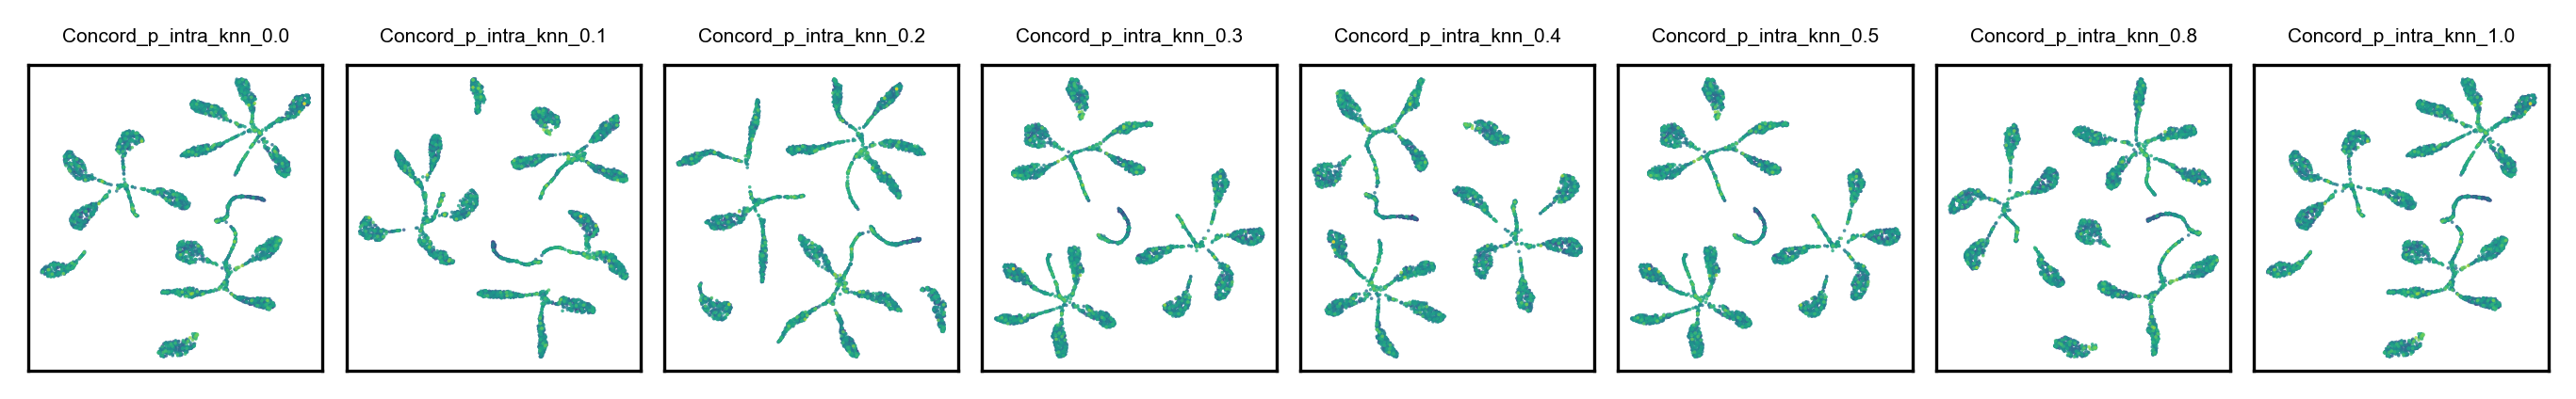

In [156]:
# Plot the degree on the UMAP

basis_types = ['UMAP']
color_bys = ['degree']
font_size=5
point_size=3
alpha=0.8
figsize=(9,1.3)
ncols = len(param_keys)
nrows = int(np.ceil(len(param_keys) / ncols))
pal = {'degree':'viridis'}
k=15
edges_color='grey'
edges_width=0.05
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        param_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=1,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix,
        save_format='pdf'
    )


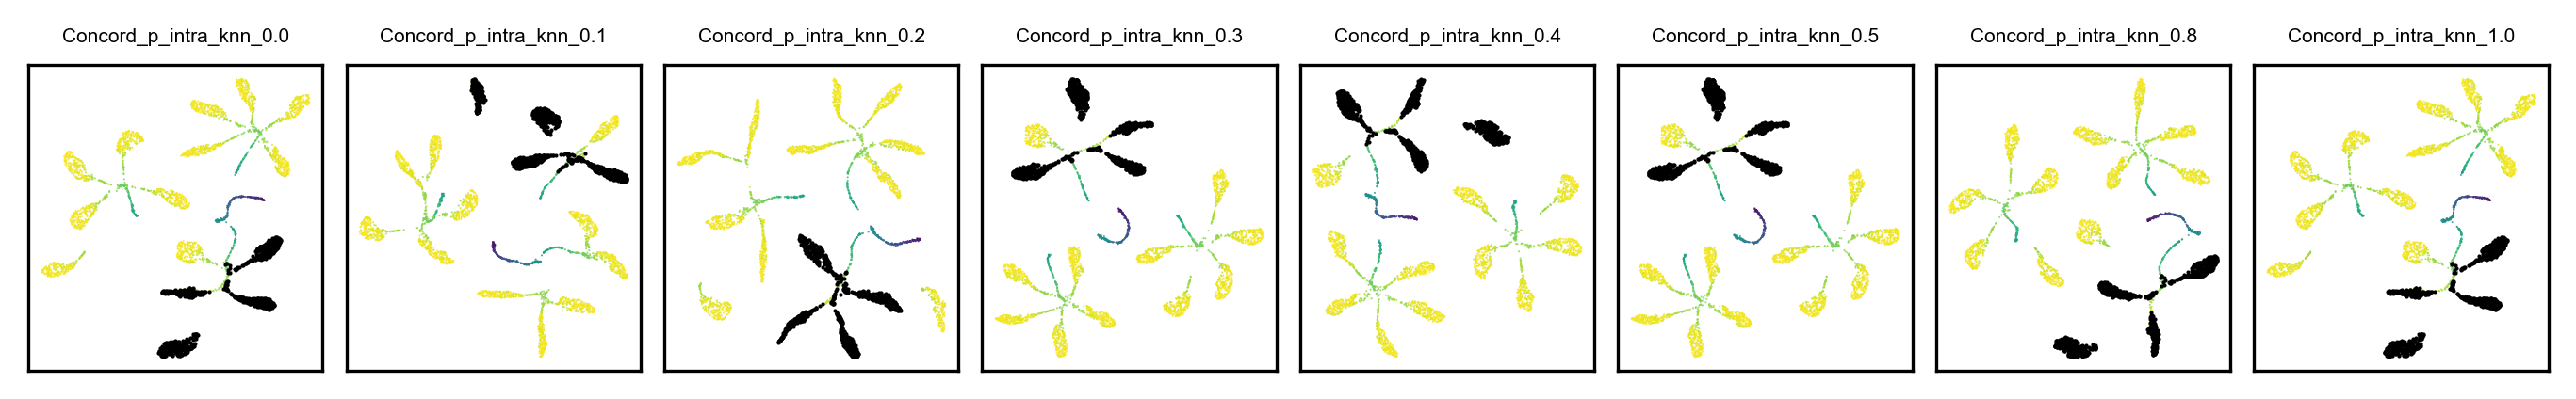

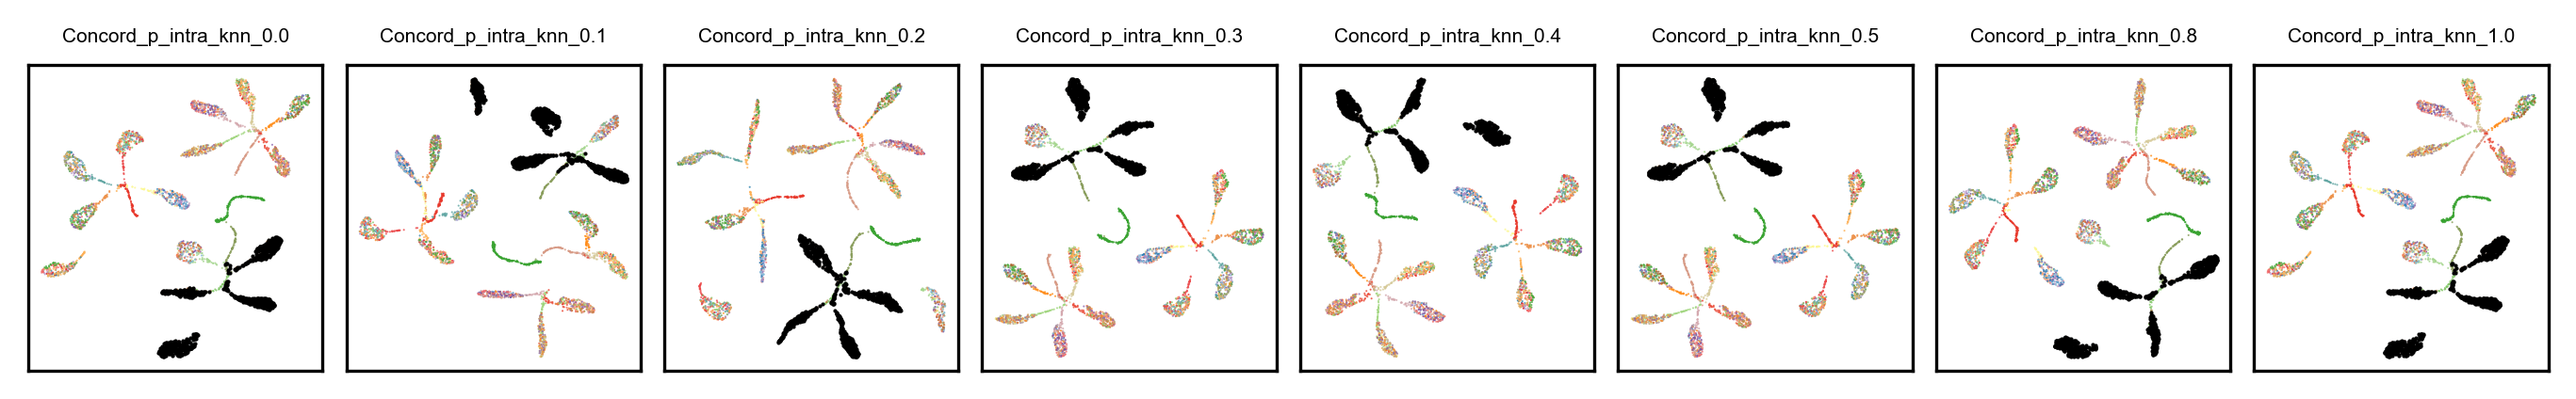

In [ ]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rcParams
file_suffix = f"{time.strftime('%b%d-%H%M')}"
# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

color_bys = ['time', state_key]
#basis_types = ['', 'PAGA', 'KNN', 'PCA', 'UMAP']
basis_types = ['UMAP']
font_size=5
point_size=1
alpha=0.8
figsize=(9,1.3)
ncols = len(param_keys)
nrows = int(np.ceil(len(param_keys) / ncols))
pal = {'time':'viridis', state_key:'Paired', batch_key:'Set1'}
k=10
edges_color='grey'
edges_width=0.05
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        param_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=1,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix,
        save_format='pdf',
        highlight_indices = hl_indices[3].cpu().numpy(), highlight_color='black', highlight_size=1
    )


# Evaluation

In [5]:
adata = sc.read(data_dir / f"adata_Dec14-1907.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Dec14-1907.h5ad")

### Topology

Run topological analysis pipeline:

In [27]:
run_methods = ["PCA", "UMAP", "t-SNE", "DiffusionMap", "NMF", 
             "FactorAnalysis", "FastICA", "LDA", "ZIFA", "scVI", "PHATE", 
             "Concord", "Concord-decoder"]
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys = ['no_noise_PCA', 'wt_noise_PCA'] + [key for key in run_methods if key not in exclude_keys]
combined_keys

['no_noise_PCA',
 'wt_noise_PCA',
 'DiffusionMap',
 'NMF',
 'FactorAnalysis',
 'FastICA',
 'LDA',
 'ZIFA',
 'scVI',
 'PHATE',
 'Concord',
 'Concord-decoder']

In [28]:
homology_dimensions = [0,1,2]
diagrams = {}
for key in combined_keys:
    print(f"Computing persistent homology for {key}")
    diagrams[key] =  ccd.ul.compute_persistent_homology(adata, key=key, homology_dimensions=homology_dimensions)

import pickle
with open(save_dir / f"topology_diagrams_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(diagrams, f)

Computing persistent homology for no_noise_PCA
Computing persistent homology for wt_noise_PCA
Computing persistent homology for DiffusionMap
Computing persistent homology for NMF
Computing persistent homology for FactorAnalysis
Computing persistent homology for FastICA
Computing persistent homology for LDA
Computing persistent homology for ZIFA
Computing persistent homology for scVI
Computing persistent homology for PHATE
Computing persistent homology for Concord
Computing persistent homology for Concord-decoder


In [29]:
save_dir / f"topology_diagrams_{file_suffix}.pkl"

PosixPath('../save/dev_simulation_tree_singlebatch-Dec14/topology_diagrams_Dec14-1907.pkl')

In [ ]:
import pickle
with open(Path('../save/dev_simulation_oneloop_singlebatch-Dec14/topology_diagrams_Dec14-1907.pkl'), 'rb') as f:
    diagrams = pickle.load(f)

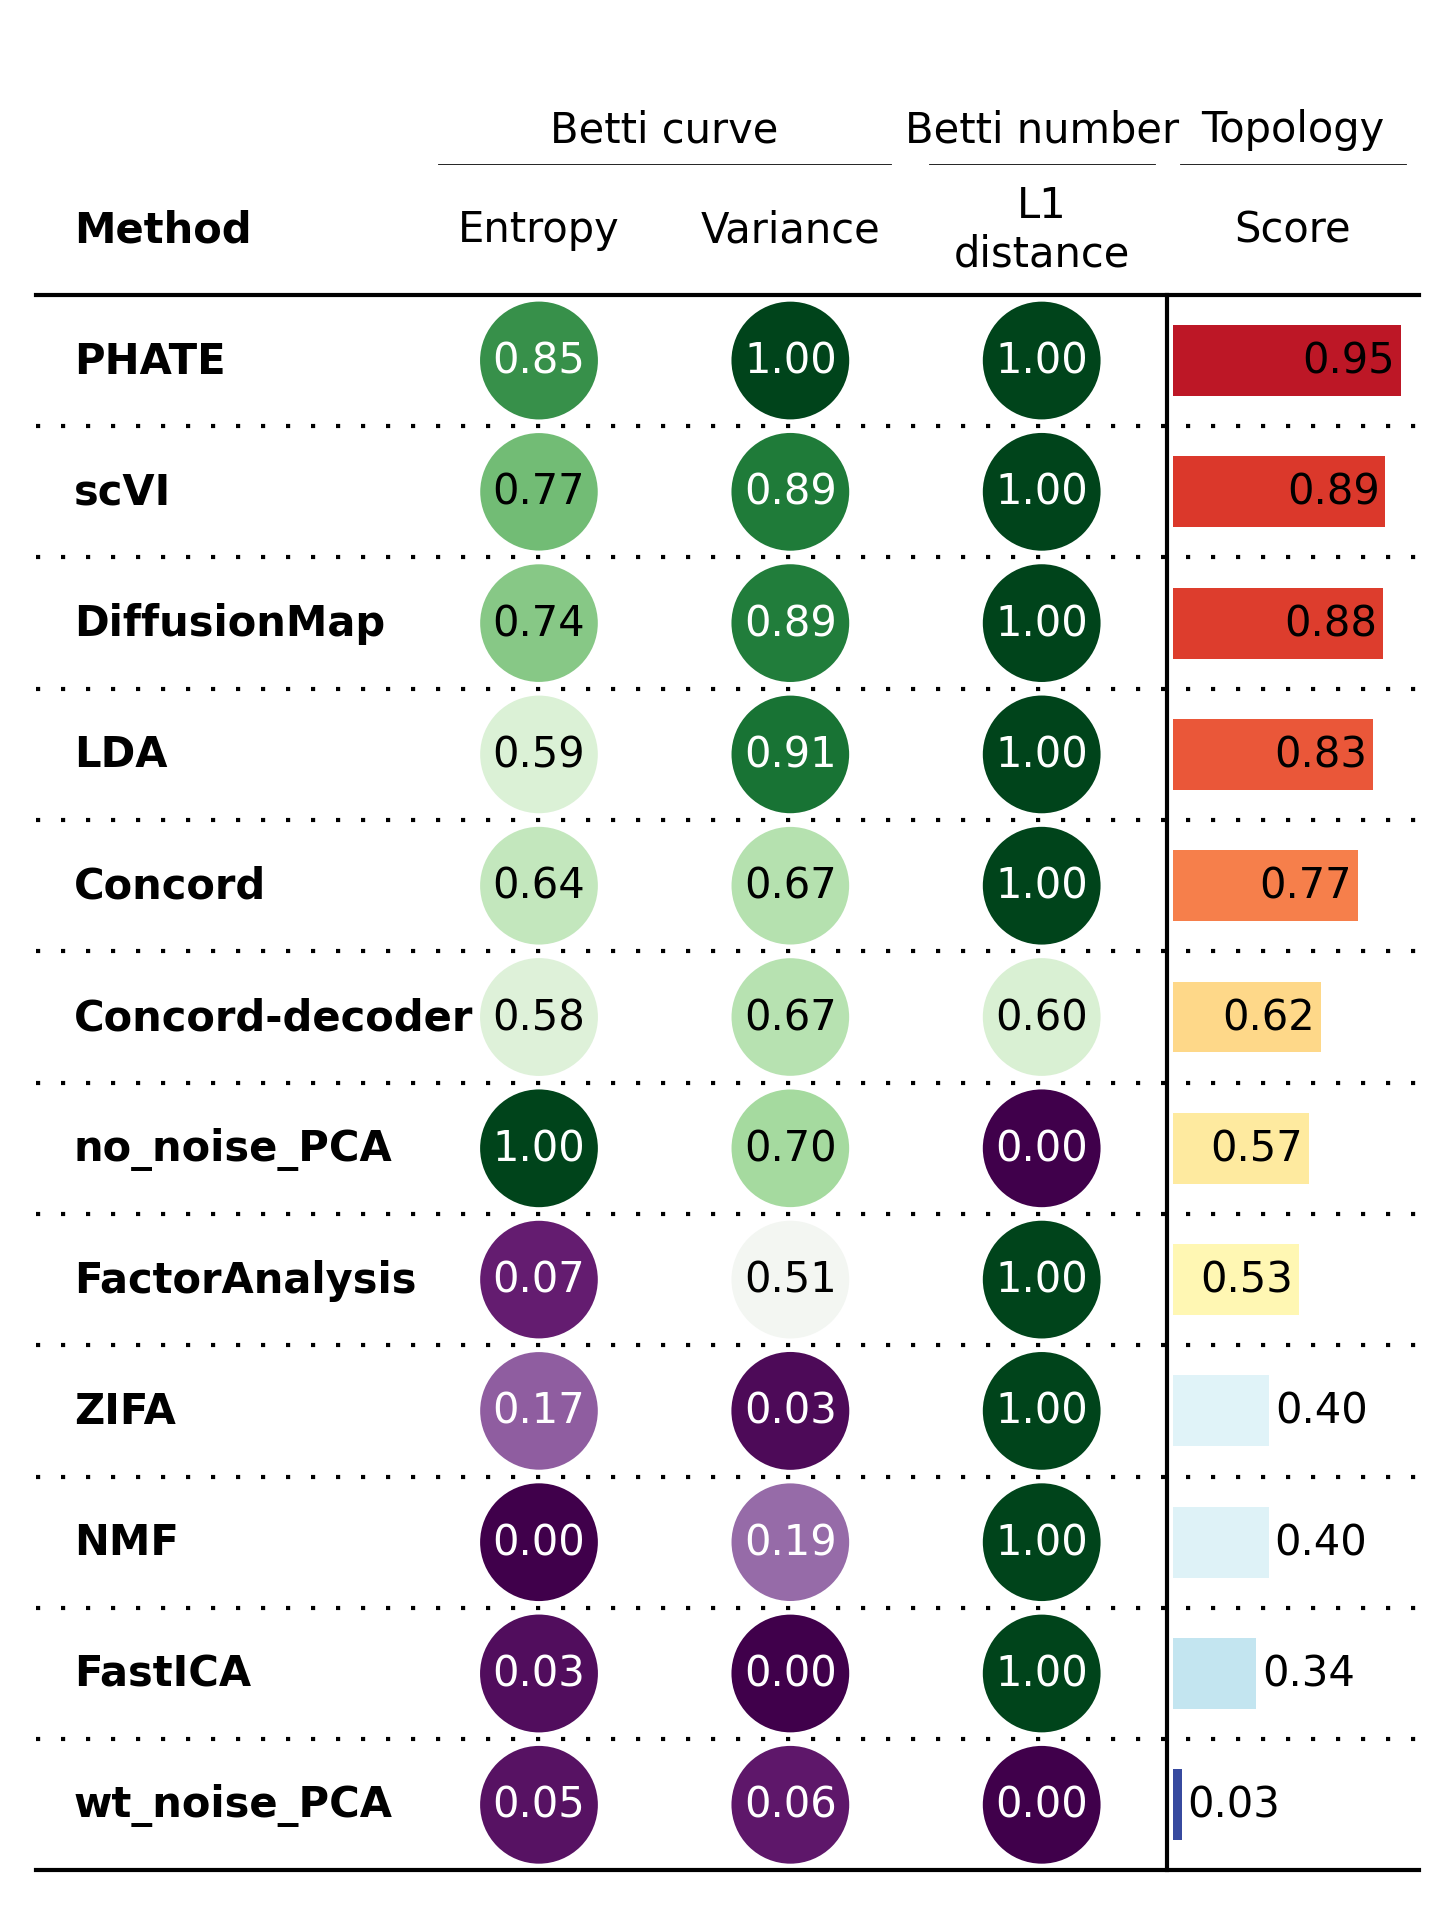

In [30]:
topology_results = ccd.ul.benchmark_topology(diagrams, expected_betti_numbers=[0,0,0], save_dir=save_dir, file_suffix=file_suffix)
max_betti = 5
topology_metrics = topology_results['combined_metrics']#.drop(index=['no_noise_PCA', 'wt_noise_PCA'])
topology_metrics[('Betti number', 'L1 distance')] = topology_metrics[('Betti number', 'L1 distance')].clip(upper=5)
agg_name1 = 'Topology'
agg_name2 = 'Score'
topology_scores = ccd.ul.benchmark_stats_to_score(topology_metrics, min_max_scale=True, one_minus=True, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2), name_exact=False)
ccd.pl.plot_benchmark_table(topology_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"topology_results_{file_suffix}.pdf", figsize=(6, 8), dpi=300)

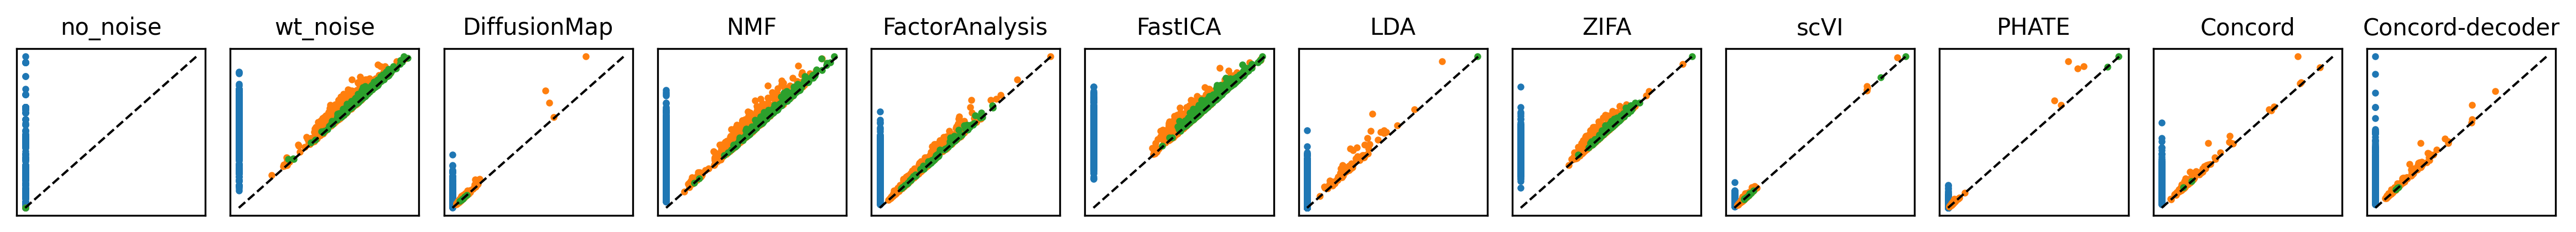

In [31]:
# Reorder diagrams with the same order as the combined keys
diagrams_ordered = {key: diagrams[key] for key in combined_keys}
# Change the key names to remove 'PCA_'
diagrams_ordered = {key.replace('_PCA', ''): diagrams_ordered[key] for key in diagrams_ordered}
ccd.pl.plot_persistence_diagrams(diagrams_ordered, base_size=(1.3, 1.5), dpi=300, marker_size=4, n_cols=12, fontsize=10, save_path=save_dir / f"persistence_diagrams_{file_suffix}.pdf", legend=False, label_axes=False, axis_ticks=False)

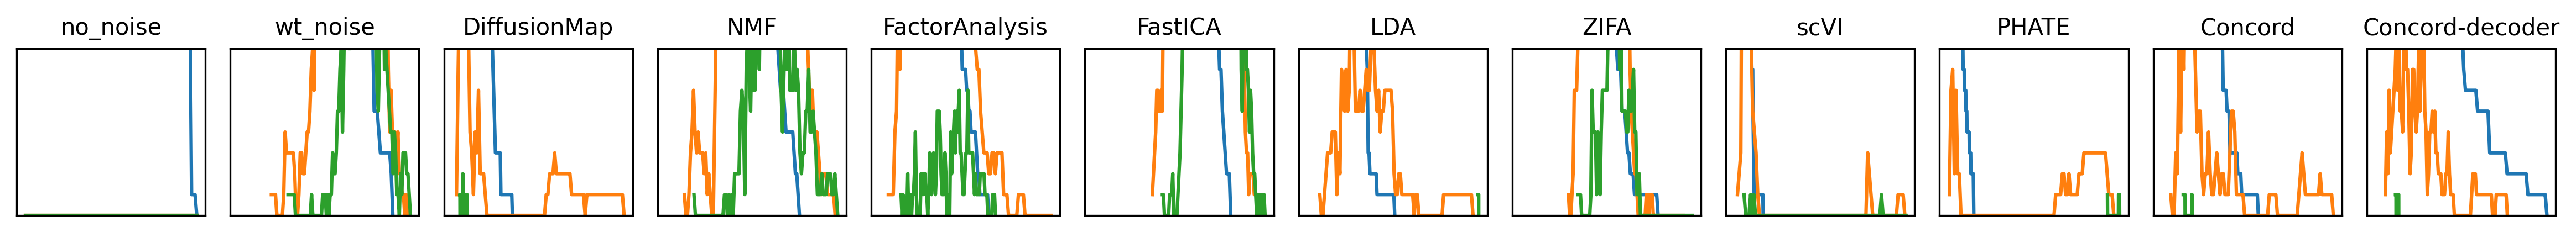

In [32]:
ccd.pl.plot_betti_curves(diagrams_ordered, nbins=100, base_size=(1.3, 1.5), n_cols=12, fontsize=10, save_path=save_dir / f"betti_curves_{file_suffix}.pdf", dpi=300, legend=False, label_axes=False, axis_ticks=False)

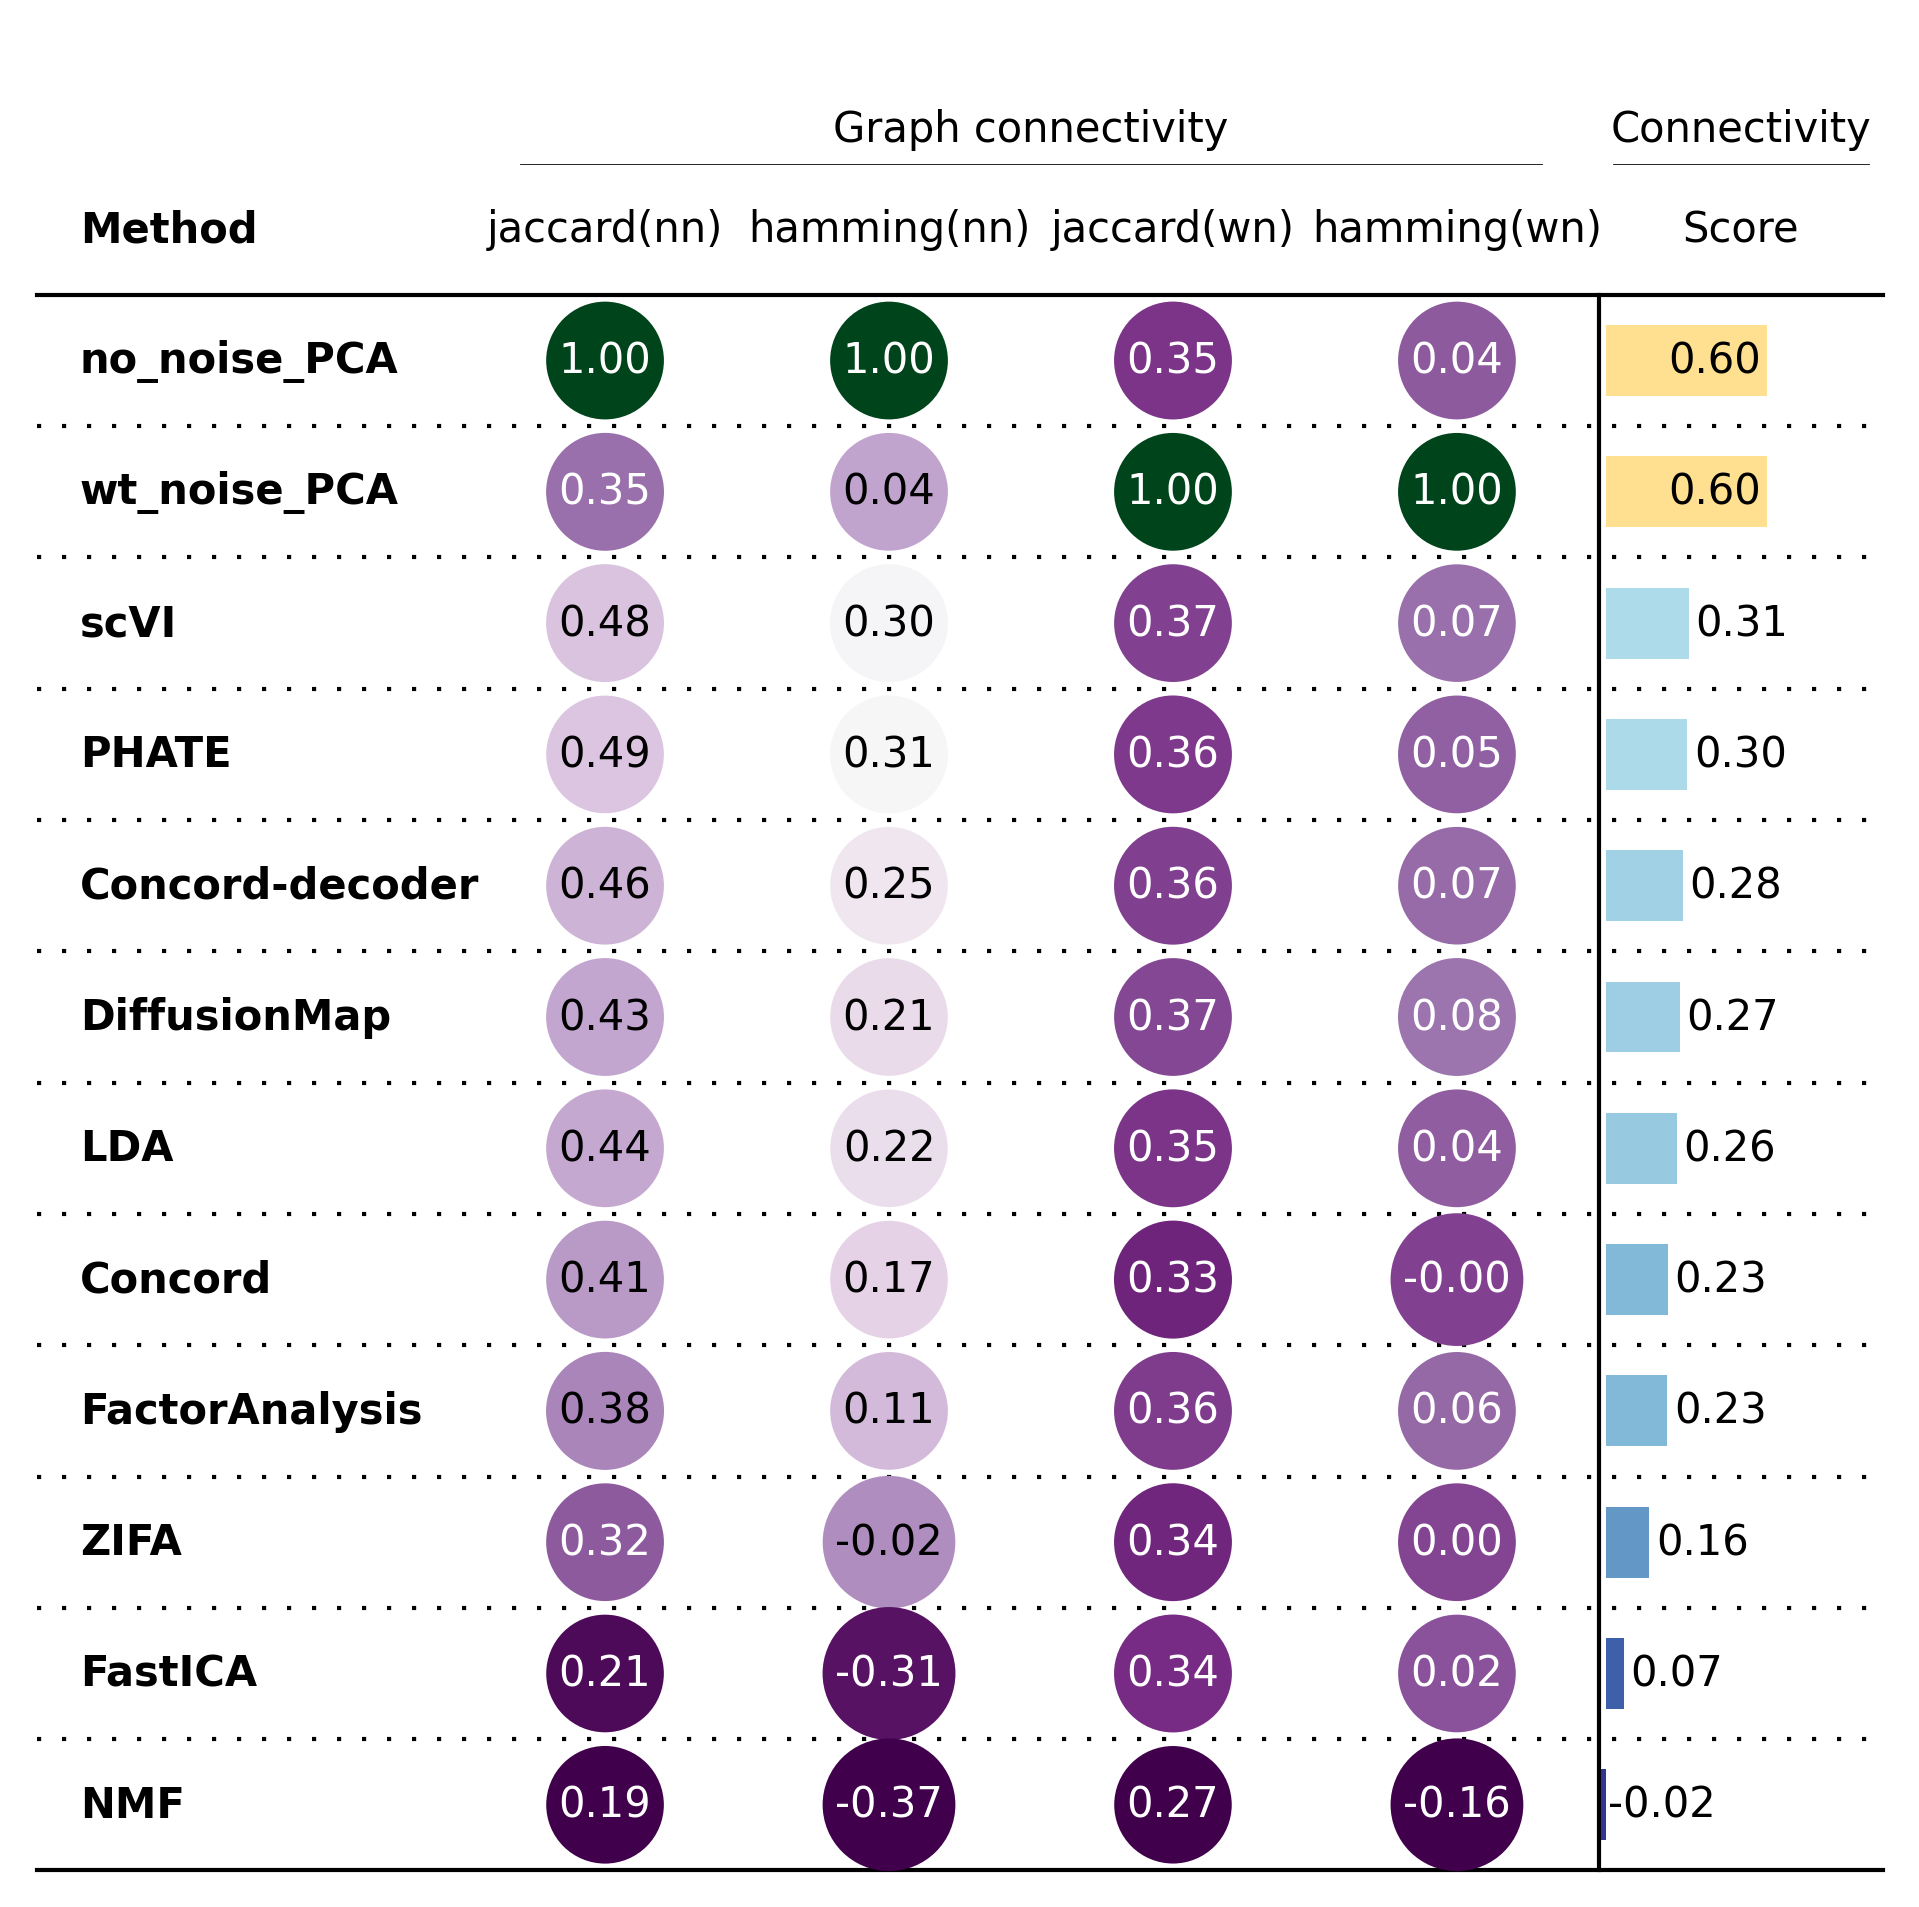

In [33]:
# compare connectivity for latent vs ground truth, store the result in a pandas dataframe
groundtruth_keys = {'(nn)': 'no_noise_PCA','(wn)': 'wt_noise_PCA'}
connectivity_df = ccd.ul.benchmark_graph_connectivity(adata, emb_keys=combined_keys, groundtruth_keys=groundtruth_keys, k=30)
agg_name1 = 'Connectivity'
agg_name2 = 'Score'
connectivity_scores = ccd.ul.benchmark_stats_to_score(connectivity_df, min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2), name_exact=False)
ccd.pl.plot_benchmark_table(connectivity_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"connectivity_results_{file_suffix}.pdf", figsize=(8, 8), dpi=300)


# Geomtric Features 

### Integrated benchmark pipeline

In [40]:
geometry_metrics = ['cell_distance_corr', 'local_distal_corr', 'trustworthiness', 'state_distance_corr', 'state_dispersion_corr']
dist_metric = 'cosine'
corr_types = ['pearsonr', 'spearmanr', 'kendalltau']
groundtruth_key = 'wt_noise_PCA'
groundtruth_key = 'no_noise_PCA'
# Convert state_dispersion to a dict of groundtruth dispersion
#groundtruth_dispersion = {'cluster_' + str(i): state_dispersion[i]**2 for i in range(5)} # convert to variance
geometry_df, geometry_full = ccd.ul.benchmark_geometry(adata, keys=combined_keys, eval_metrics=geometry_metrics, 
                                      dist_metric=dist_metric,
                                      corr_types = corr_types,
                                      groundtruth_key = groundtruth_key,
                                      state_key = leiden_key,
                                      batch_key = batch_key,
                                      #groundtruth_dispersion = groundtruth_dispersion,
                                      dispersion_metric='var',
                                      return_type='full',
                                      start_point=0,
                                      end_point=adata.n_obs-1,
                                      pseudotime_k = 30,
                                      truetime_key = 'time',
                                      save_dir=save_dir, 
                                      file_suffix=file_suffix)

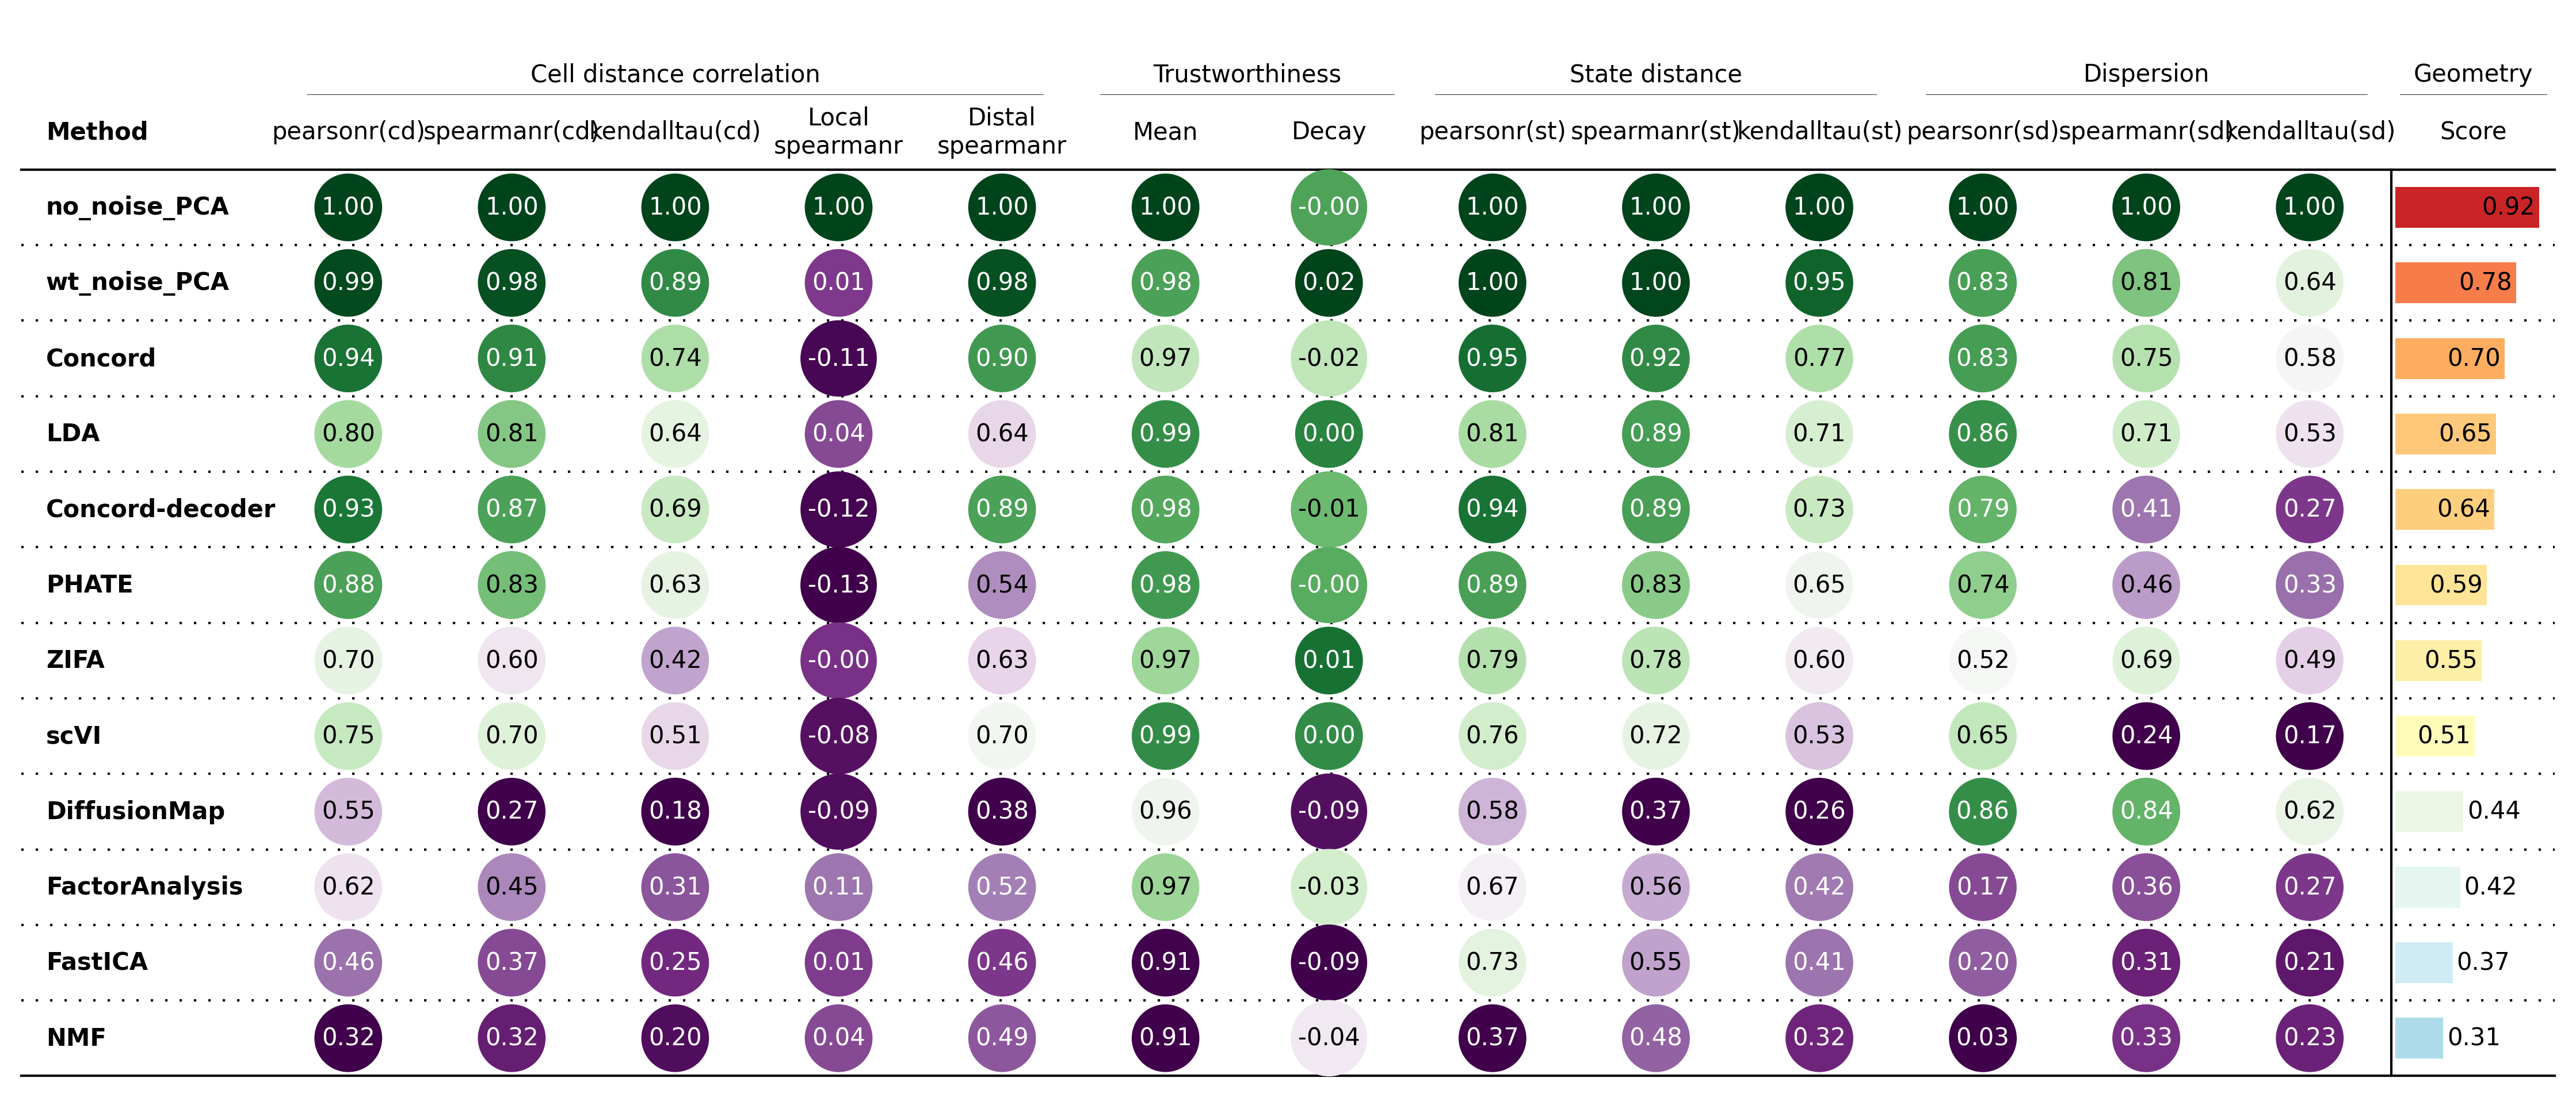

In [41]:
agg_name1 = 'Geometry'
agg_name2 = 'Score'
geometry_scores = ccd.ul.benchmark_stats_to_score(
    geometry_df, fillna = 0,               
    min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2))
ccd.pl.plot_benchmark_table(geometry_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"geometry_results_noscale_{dist_metric}_{groundtruth_key}_{file_suffix}.pdf", figsize=(19, 8), dpi=300)

In [42]:
geometry_full['Pseudotime']['pseudotime'].keys()

KeyError: 'Pseudotime'

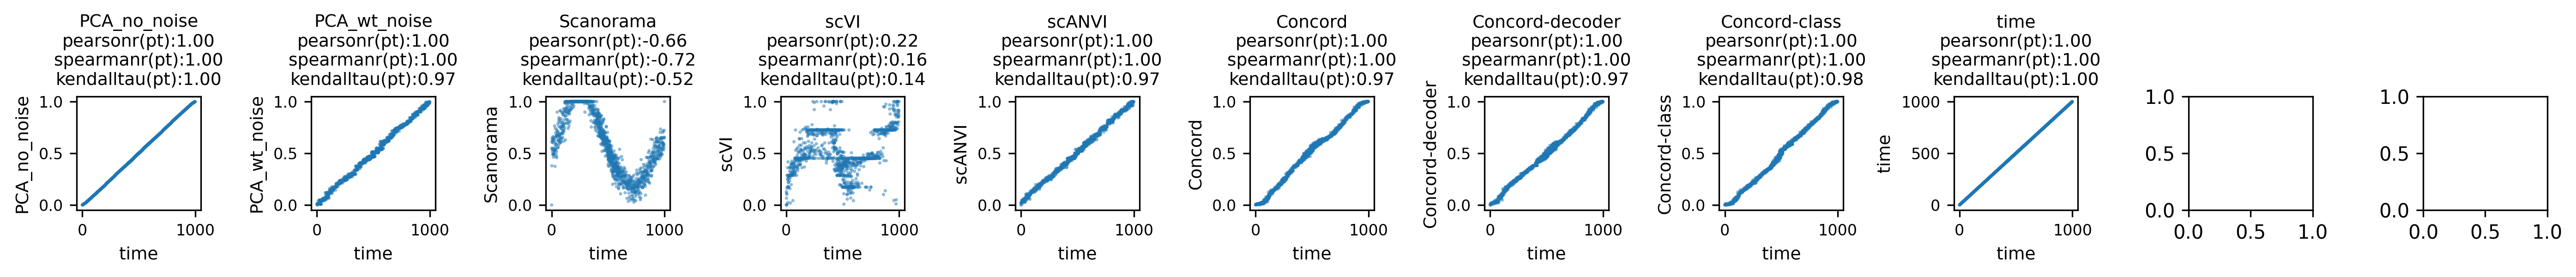

In [30]:
ccd.pl.plot_geometry_scatter(
    data_dict = geometry_full['Pseudotime']['pseudotime'], 
    correlation= geometry_full['Pseudotime']['correlation'],
    s=3,
    ground_key = 'time', fontsize=9,
    n_cols = 11, figsize=(1.7,2.1), dpi=300, save_path=save_dir / f"pseudotime_scatter_{groundtruth_key}_{file_suffix}.pdf")

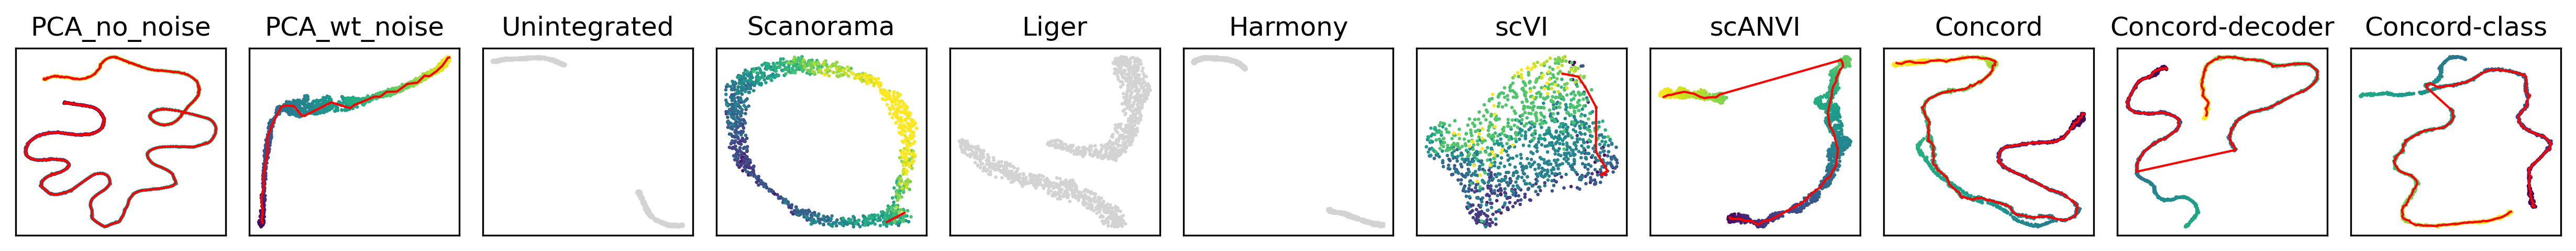

In [32]:
import matplotlib.pyplot as plt

n_cols = 11
n_rows = int(np.ceil(len(combined_keys) / n_cols))
base_size = (1.5, 1.7)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*base_size[0], n_rows*base_size[1]), dpi=300)

axes = np.atleast_2d(axes).flatten()
for basis in combined_keys:
    show_basis = basis + '_UMAP'
    if show_basis not in adata.obsm or basis not in geometry_full['Pseudotime']['pseudotime']:
        show_indices = None
        adata.obs['pseudotime_plot'] = np.nan
    else:
        show_indices = geometry_full['Pseudotime']['path'][basis]
        adata.obs['pseudotime_plot'] = geometry_full['Pseudotime']['pseudotime'][basis]
    
    show_cols = ['pseudotime_plot']

    ccd.pl.plot_embedding(
        adata, show_basis, show_cols, highlight_indices=show_indices, highlight_size=5, draw_path=True, alpha=1.0,
        font_size=12, point_size=10, path_width=1,
        legend_loc='on data', title=basis, colorbar_loc=None, rasterized=True, xlabel=None, ylabel=None, 
        ax=axes[combined_keys.index(basis)]
    )

plt.tight_layout()
plt.savefig(save_dir / f"pseudotime_embedding_{file_suffix}.pdf")

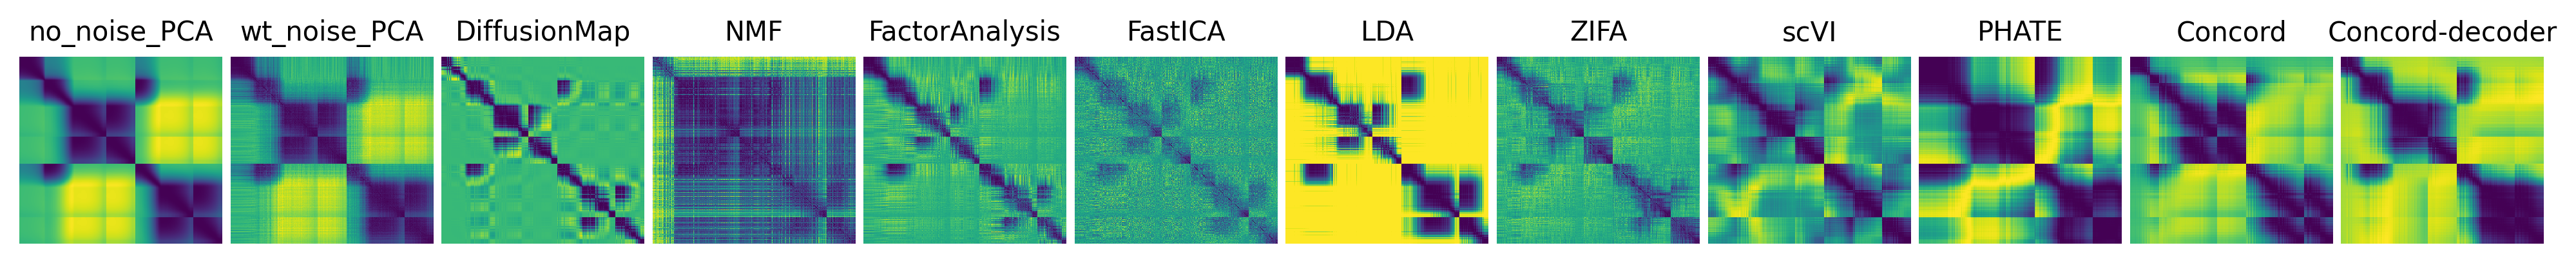

In [37]:
ccd.pl.plot_distance_heatmap(geometry_full['cell_distance_corr']['distance'], n_cols = 12, figsize=(1.1,1.3), cbar=False, dpi=300, save_path=save_dir / f"cell_distance_hmap_{file_suffix}.svg")

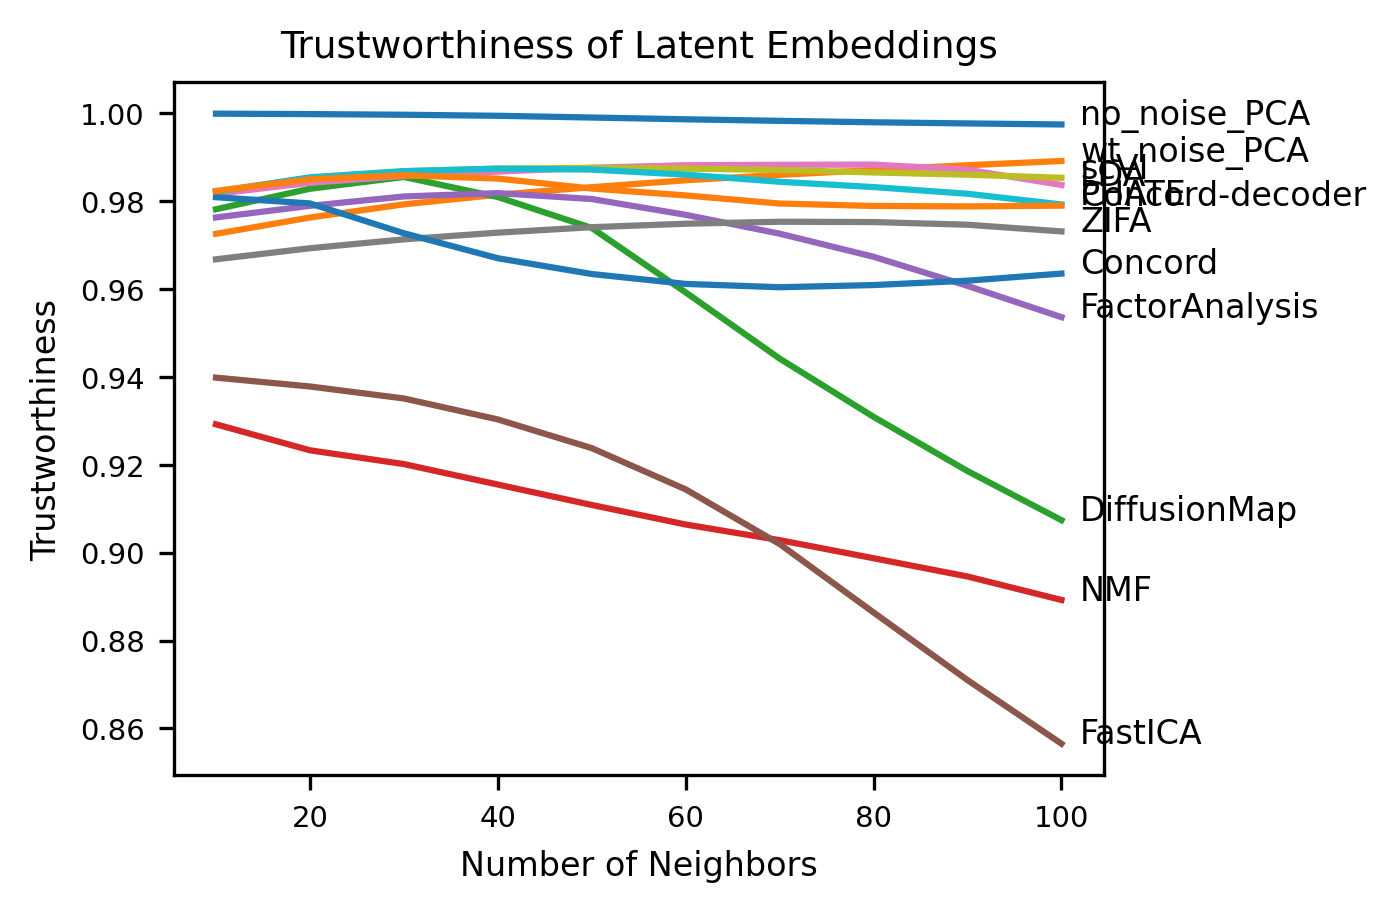

In [43]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=2, legend=False, save_path=save_dir / f"trustworthiness_{groundtruth_key}_{file_suffix}.pdf", figsize=(4,3))

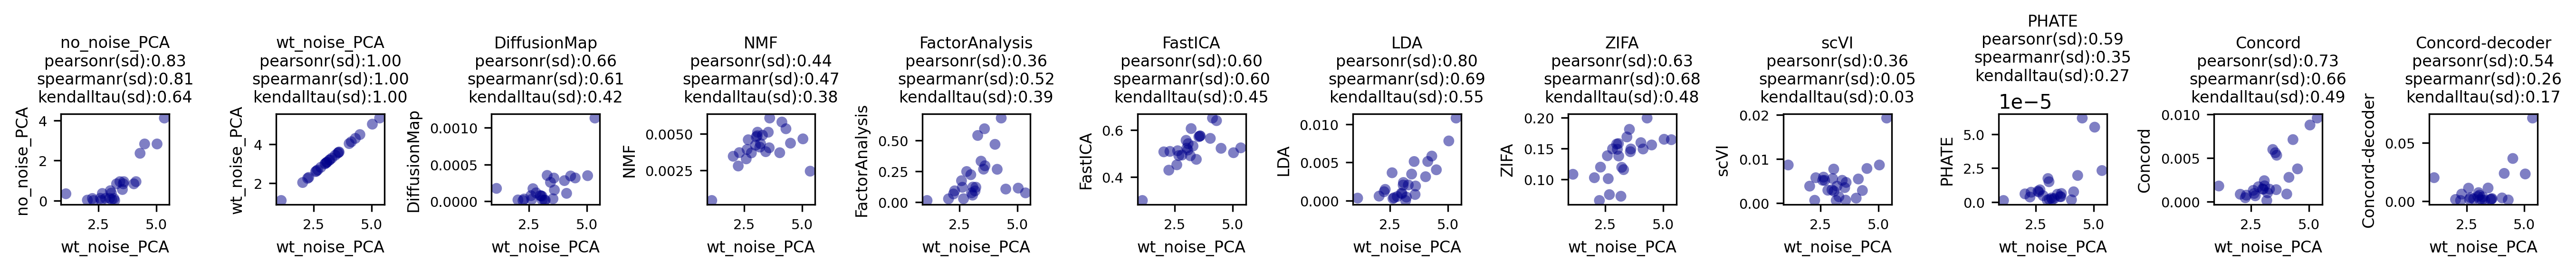

In [39]:
ccd.pl.plot_geometry_scatter(
    data_dict = geometry_full['state_dispersion_corr']['dispersion'], 
    correlation= geometry_full['state_dispersion_corr']['correlation'],
    s=30, c='darkblue',
    ground_key = groundtruth_key,
    n_cols = 12, figsize=(1.5,2.0), dpi=300, save_path=save_dir / f"state_dispersion_scatter_{groundtruth_key}_{file_suffix}.pdf")